## CREAZIONE DELL'AMBIENTE DI LAVORO

#### ACQUISIZIONE DEL DATASET

In [ ]:
import os

# NB: come scritto nel readme questa parte non è fondamentale se ci sono gia' i file
# necessari nella cartella /data/

# Cambiare le credenziali kaggle per poter scaricare i dati
# Si uncommenti e si cambino le stringhe con le proprie credenziali
# os.environ['KAGGLE_USERNAME'] = "your_username"
# os.environ['KAGGLE_KEY'] = "your_password"

# Download di tutti i file .csv presenti nel dataset di instgram
!kaggle datasets download -p ./data -d bhanupratapbiswas/instgram --unzip 

#### CONTAINER NEO4J


Per fare il build e lo start del container di neo4j (si parte dalla empty sandbox) si deve far girare nella cartella del progetto contente `docker-compose.yml` il comando riportato di seguito.
```bash
sudo docker-compose up
```

Nel caso in cui dovesse riscontrarsi il seguente errore  `Error response from daemon: network <id_network> not found` cio' che bisogna fare e' aggiungere una semplice opzione al comando precedente.
```bash
sudo docker-compose up --force-recreate
```

Nel caso invece dovesse riscontrarsi l'errore `Cannot connect to the Docker daemon` allora dovete avviare il deamon docker in questo modo:
```bash
systemctl start docker
```
o in maniera analoga con
```bash
sudo systemctl start docker
```

**NB**: Nell'ambiente di visual studio non si riesce, purtroppo, a far girare comandi di questo tipo in modo interattivo (nessuna possibilità di immettere la password).
Si e' anche valutato se mettere la password in un file .env e richiamarla da riga di comando ma non sarebbe stata sicura. Per questo si richiede all'utente di immeterlo da terminale.

Prima di continuare aspettare la conferma dell'avvio del container, come in figura:
![container neo4j](media/container_start.png)

#### CONNESSIONE AL DATABASE

In [2]:
from neo4j import GraphDatabase as gd

# Prima di arrivare a questo punto si controlli di aver correttamente attivato il container
# Nel caso in cui ci siano dubbi su ip/porta da usare si controlli nel log docker alla voce "bolt"
URI = "bolt://localhost:7688" 

d   = gd.driver(URI, auth=None)
d.verify_connectivity()


#### CREAZIONE DATABASE

In [3]:
s   = d.session()

# Prova a creare un nuovo database vuoto col nome di instagram
# Che ci fosse gia' o meno alla fine setta la sessione sul database instagram
# Lo si fa all'inizio per non dover specificare ogni volta su che database fare le query
try:
    s.run("create database instagram").data() 
except: 
    s = d.session(database="instagram")
finally:
    s = d.session(database="instagram")

In [3]:
# La creazione dei constraint viene fatta per ogni nodo che sara' presente
# I constraint in questione specificano tutti l'unicita' dell'ID per ogni nodo
s.run("create constraint UniqueUserID if not exists for (u:User) require u.id is unique;")
s.run("create constraint UniqueCommentID if not exists for (c:Comment) require c.id is unique;")
s.run("create constraint UniquePostID if not exists for (p:Post) require p.id is unique;")
s.run("create constraint UniqueTagID if not exists for (t:Tag) require t.id is unique;")

# Nel caso in cui il constraint esista gia' non verrà creato nessun errore grazie a 'if not exists'


Accedendo a http://localhost:7474 e poi con nessuna autenticazione a bolt://localhost:7688 si può:
* controllare che esiste il database instagram
    ```cypher 
    :dbs
* entrare nel database
    ```cypher
    :use instagram
* controllare che siano stati aggiunti i quattro constraint
    ```cypher
    :schema

In [4]:
# Si è fatto un test per essere sicuri di come e dove trovare tutti i csv
# La stampa ritorna il numero di righe del file (8782)
res = s.run('''load csv with headers
                from 'file:///likes.csv' as line
                return count(line)''').data()
print(res)

[{'count(line)': 8782}]


#### AGGIUNTA NODI

In [5]:
# Si e' notato che le date di creazione di tag, commenti e foto sono tutte fabbricate
# lo stesso giorno
# Si e' deciso quindi di non usarle in quanto di poca utilita'

# Per i nodi user non vengono messe le properties 'post count' 
# e 'verified status' in quanto la prima si puo' ricavare e la seconda 
# non sembra importante per le analisi che si faranno
s.run('''load csv with headers
         from 'file:///users.csv' as row
         with row merge (u:User{id:toInteger(row.id)})
         on create set
            u.name = row.name,
            u.created = toString(row.`created time`), 
            u.type = toString(row.`private/public`)''')

s.run('''load csv with headers from 'file:///tags.csv' as row 
         with row merge (t:Tag{id:toInteger(row.id)}) 
         on create set 
            t.text = toString(row.`tag text`), 
            t.location = toString(row.location) ''')

# Per le foto non vengono caricati i link in quanto non servono per l'analisi che si fara'
s.run('''load csv with headers from 'file:///photos.csv' as row 
         with row merge (p:Post{id:toInteger(row.id)}) 
         on create set
            p.filter = toString(row.`Insta filter used`),
            p.type = toString(row.`photo type`) ''')


s.run('''load csv with headers from 'file:///comments.csv' as row 
         with row merge (c:Comment{id:toInteger(row.id)}) 
         on create set
            c.text = toString(row.comment) ''')

#### AGGIUNTA RELAZIONI

In [6]:
# Relazione di creazione post da parte dello user
s.run('''load csv with headers from 'file:///photos.csv' as row 
         match (p:Post{id:toInteger(row.id)})
         match (u:User{id:toInteger(row.`user ID`)}) 
         merge (p)<-[:POSTED]-(u) ''') 

# Relazione di un tag contenuto in un post
# La relazione tra tag e user può essere ricavata da user -> post -> tag
s.run('''load csv with headers from 'file:///photo_tags.csv' as row 
         match (p:Post{id:toInteger(row.photo)})
         match (t:Tag{id:toInteger(row.`tag ID`)}) 
         merge (p)-[:HAS_TAG]->(t) ''') 

# Relazione di un like di uno user su un post
# Anche in questo caso il 'created time' e' stato fabbricato e non viene quindi preso in considerazione
# La properties 'following or not' si può invece ricavare e non viene quindi settata
s.run('''load csv with headers from 'file:///likes.csv' as row 
         match (p:Post{id:toInteger(row.photo)})
         match (u:User{id:toInteger(row.`user `)}) 
         merge (p)<-[:LIKE {type: row.`like type`}]-(u) ''') 

# Relazione di follow tra user
# Anche in questo caso le properties 'is follower active' e 'followee Acc status' non sono fondamentali
# e possono essere ricavate dalle varie relazioni e properties gia' salvate
s.run('''load csv with headers from 'file:///follows.csv' as row 
         match (a:User{id:toInteger(row.follower)})
         match (b:User{id:toInteger(row.`followee `)}) 
         merge (a)-[:FOLLOWS]->(b) ''') 

# Relazione di un commento sotto un post
s.run('''load csv with headers from 'file:///comments.csv' as row 
         match (c:Comment{id:toInteger(row.id)})
         match (p:Post{id:toInteger(row.`Photo id`)}) 
         merge (p)<-[:COMMENT_ON]-(c) ''') 

# Relazione di uno user che crea un commento
s.run('''load csv with headers from 'file:///comments.csv' as row 
         match (c:Comment{id:toInteger(row.id)})
         match (u:User{id:toInteger(row.`User  id`)}) 
         merge (c)-[:COMMENTED_BY]->(u) ''') 


#### AGGIUNTA INDICI

In [7]:
# Si sceglie di creare dei text index per un po' tutte le proprieta' dei nodi
# questo perchè tutti i campi sono in formato di stringa e non si pensa di aver mai 
# bisogno di alzare le performance di operazioni numeriche (range indexes)
s.run('''create text index for (u:User) on (u.name)''')
s.run('''create text index for (u:User) on (u.type)''')

s.run('''create text index for (t:Tag) on (t.text)''')
s.run('''create text index for (t:Tag) on (t.location)''')

s.run('''create text index for (p:Post) on (p.type)''')

s.run('''create text index for (c:Comment) on (c.text)''')

# Gli id sono fatti invece di default dai constraint di unicita'

## EXPLORATORY DATA ANALYSIS

Per visionare lo schema generale del nostro grafo appena creato si puo' lanciare il comando:
```cypher
call db.schema.visualization()
```

Il risultato di questa operazione dovrebbe essere:

![graph](media/graph_schema.png)

<Axes: ylabel='count'>

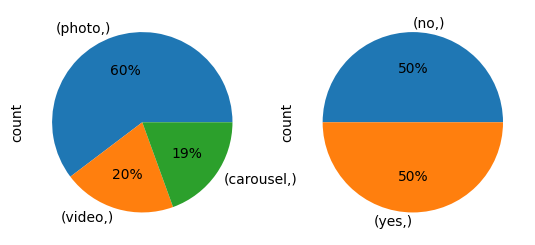

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
a = plt.subplots(nrows=1, ncols=2)[1]

res = s.run('''match (p:Post) return p.type''').data()
pd.DataFrame(res).value_counts().plot(ax=a[0], y="type", kind="pie", autopct='%1.0f%%')

res = s.run('''match (u:User) return u.type''').data()
pd.DataFrame(res).value_counts().plot(ax=a[1], y="type", kind="pie", autopct='%1.0f%%')

# Si nota come per i post sia piu' ricorrente fare foto rispetto a video e carousel
# questo potrebbe essere dato dal fatto che sono gli utenti piu' attivi generano tanti 
# tipi di contenuti mentre quelli meno attivi generano quasi solo foto.

# Per la tipologia di utente (yes=private, no=public) non vi è alcuna differenza
# da notare come non viene spiegato perfettamente il significato di yes/no 
# ma si interpreta come private/public (nome proprietà) = yes/no.

<Axes: ylabel='count'>

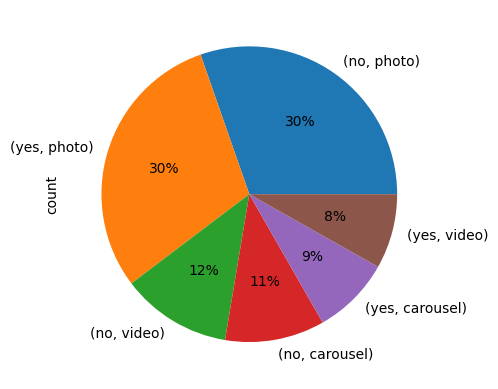

In [9]:
# Proviamo a dare una risposta all'ipotesi avanzata nel precedente commento
res = s.run('''match (p:Post)<-[:POSTED]-(u:User) 
            return u.type as user_type, p.type as post_type''').data()

pd.DataFrame(res).value_counts().plot(y="post_type", kind="pie", autopct='%1.0f%%')

# Come si può vedere dalla torta il numero di foto create da utenti privati e non è in ugual misura
# Per quanto riguarda invece i contenuti sia video che reel la percentuale è maggiore
# per utenti pubblici che privati 

<Axes: ylabel='count'>

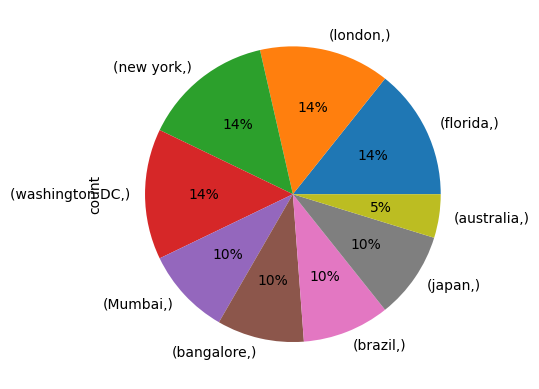

In [10]:
# Per completare la visualizzazione della moda delle properties piu' importanti
# aggiungiamo il grafico sulle percentuali delle location taggate
res = s.run('''match (t:Tag) return t.location''').data()
pd.DataFrame(res).value_counts().plot(y="location", kind="pie", autopct='%1.0f%%')

Quello che si potrebbe provare a estrapolare da questi ultimi dati è che il dataset rispecchia in piccola parte i veri dati di instagram dei post per continente.
Questa teoria viene in parte provata da alcuni dei grafici di questo [studio](https://mention.com/en/reports/instagram/instagram-report-location/).
Il numero di post maggiori e' dato da regioni USA e questo spiega come mai NYC, Florida e Washington siano 
ad una percentuale cosi alta. Queste regioni vengono seguite dal Brasile per cui prova anche la seconda 
percentuale migliore da parte del Brasile.
Altro dato interessante e' quello che prova la posizione cosi alta anche di Londra, essa e' la citta' con 
maggior numero di post anche prima di NYC. E prima anche tra le citta' inglesi come numero di post.
Inoltre si può notare come i continenti di Asia e Oceania hanno valori molto bassi rispetto a tutti gli altri, questo spiega come mai Australia abbia la percentuale minore. Non spiega come mai Giappone sia a parimerito con Brasile che abbiamo detto essere la seconda country per numero di post.
Infine si noti come la citta' con piu' alto tasso di interazione è stata Mumbai che verosimilmente occupa
la seconda percentuale migliore nel nostro grafico.
L'unico dato che non si riesce bene a ricostruire sembra quindi essere Bangalore.

 
Sfortunatamente non si può fare una reale predizione in quanto il dataset usato non è sicuramente completo di tutti i dati di Instagram.

          tipo  min  max    average      stdev
0         clap   13   52  22.779221  13.075312
1   double tap    2   10   6.000000   5.656854
2         fire   14   52  22.740260  13.194300
3  heart emoji   14   52  22.740260  12.996358
4     laughing   14   52  22.740260  13.054947
5   single tap    2   10   6.000000   5.656854
6    thumbs up   14   52  22.740260  12.996358


<Axes: >

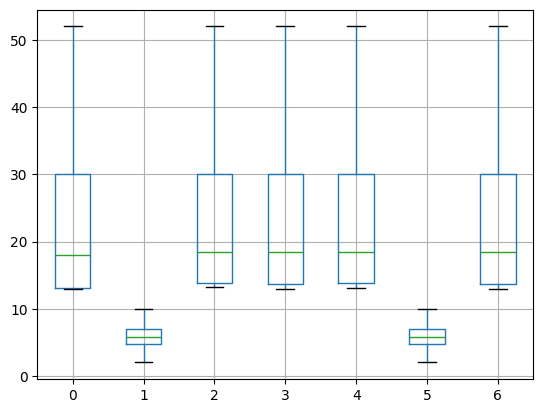

In [11]:
# Continuando con l'esplorazione dei dati cerchiamo di capire come solitamente 
# uno user reagisce ad un post (tipo di emoji usato)
res = s.run('''match (u:User)-[r:LIKE]->() with r.type as tipo, u, count(*) as degree
         return tipo, min(degree) as min, max(degree) as max, 
         avg(degree) as average, stdev(degree) as stdev order by tipo''').data()
df = pd.DataFrame(res)
print(df)

df.drop(columns='tipo').T.boxplot()

# Come ci si aspettava thumbs up, heart, fire e laughing emoji sono quelli piu' gettonati 
# con nessuno pero' migliore dell'altro
# Come si nota dal grafico double tap e single tap (1, 5) sono abbastanza simmetriche mentre le altre
# distribuzioni sono positivamente skew

   score                                               user
0    0.0  [Kenton_Kirlin, Kasandra_Homenick, Eveline95, ...
1   99.0  [Andre_Purdy85, Harley_Lind18, Arely_Bogan63, ...


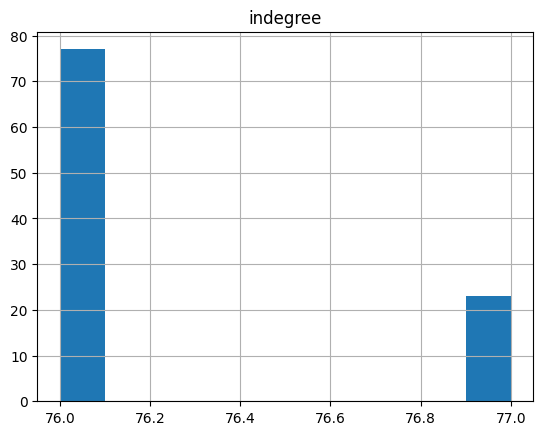

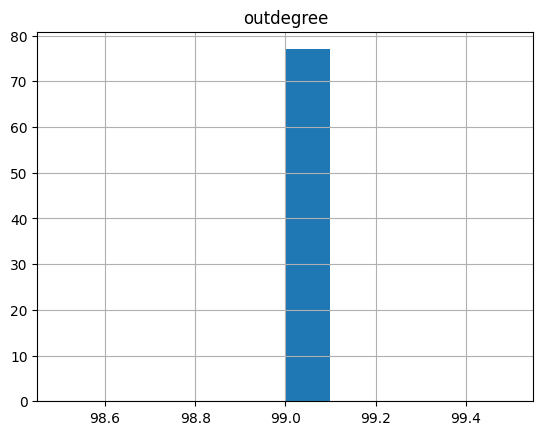

In [18]:
# Controlliamo ora come sono distribuiti il numero di follower per user (in degree)
res = s.run('''match (u:User)<-[:FOLLOWS]-() with distinct u.id as user, 
               count(*) as indegree return indegree''').data()

pd.DataFrame(res).hist()

# I valori sembrano tutti molto vicini tra loro ma, come si vede per range di valori piu' ampi
# su social network graph, riporta molti utenti con valori piu' bassi e pochi con valori alti
# Si potrebbe avanzare quindi l'ipotesi che gli utenti con valore nell'intorno di 76.9-77.0 
# siano quelli piu' seguiti

# Controlliamo ora com'e' distribuito il numero di persone seguite per user (out degree)
res = s.run('''match (u:User)-[:FOLLOWS]->() with distinct u.id as user, 
               count(*) as outdegree return outdegree''').data()

pd.DataFrame(res).hist()
# Quello che si sperava di trovare e' un grafo circa come quello precedente in quanto
# specularmente a prima gli utenti piu' seguiti sono quelli che dovrebbe seguire meno
# Il fatto che e' stato ottenuto questo risultato fa pensare che il grafo possa non rappresentare
# appieno uno small-world come invece sarebbero social di questo tipo.

# Un ulteriore modo per visionare questi risultati (forse piu' chiaramente) e' utilizzare la funzione
# gds.degree.stream() o in alternativa anche gds.degree.stats().
# Per avere performance migliori durante la ricerca creaiamo prima una proiezione
# In questo caso ci servono gli utenti e la relazione di following
# Per una semplice vista di questo tipo possiamo usare una native projection in cui consideriamo 
# solamente nodi utente e relazione di seguace-seguito.
s.run('''call gds.graph.project('follows', 'User', 'FOLLOWS')''')

res = s.run('''call gds.degree.stream('follows')
                yield nodeId, score return score, 
                collect(distinct gds.util.asNode(nodeId).name) as user''').data()
print(pd.DataFrame(res))
# Come si puo' notare abbiamo alcuni utenti che non seguono nessuno (ma che probabilemente sono seguiti)
# e altri (la maggior parte) che seguono molte persone.

In [19]:
# Si puo' quindi prevedere che le comunita' che verranno trovate corrisponderanno probabilmente ad 
# un gruppo grande (con degree centrality di 99) e tanti piccoli che sono gli utenti che non seguono nessuno
print(f'Numero di utenti che non seguono nessuno: {len(res[0]['user'])}')

res = s.run('''call gds.labelPropagation.stream('follows') yield  nodeId as n, communityId as c 
         return distinct c as community, count(*) as people''').data()

print(pd.DataFrame(res))
# Come si puo' notare le comunita' da 1 solo utente trovate sono 23, esattamente il numero trovato 
# dallo studio della centralita'.

Numero di utenti che non seguono nessuno: 23
    community  people
0           0      78
1           6       1
2          22       1
3          24       1
4          28       1
5          33       1
6          44       1
7          48       1
8          50       1
9          52       1
10         57       1
11         58       1
12         63       1
13         67       1
14         73       1
15         76       1
16         79       1
17         80       1
18         82       1
19         85       1
20         87       1
21         88       1
22         89       1


Volendo si può anche provare un'alternativa alla native projection che è la cypher (ma in questo caso sarebbe molto meno performante):
```python
s.run('''call gds.graph.project.cypher      
    ('follow', 
    'match (u:User) return u.id as id', 
    'match (a:User)-[r:FOLLOWS]-(b:User)
    return distinct a.id as source, 
    b.id as target, type(r) as type') ''')
```

Come si era predetto dai risultati 'strani' del grafico degli outdegree notiamo che viene segnalata una comunita' molto grande e tutte le altre 23 con un solo individuo.
Cio' probabilmente vuol dire che ci troviamo in presenza di un grafico molto connesso in cui la maggior parte degli utenti e' connessa con l'altra.
Questo è verosimilmente provato dal fatto che usando l'algoritmo di pagerank tutti i nodi hanno valore di score praticamente uguale (0.43) e che la differenza si nota solo dopo la terza cifra decimale.
Come si era detto infatti e' possibile che le comunita' piccole, nonostante non seguano nessuno, vengano seguiti (indegree) dandogli cosi un valore non nullo di pageRank.
Per controllare si può lanciare:
1.  ```cypher 
    call gds.pageRank.stream('follows') 
    yield nodeId, score
    return distinct score as Score, count(*)
2. oppure 
```python 
    res = s.run('''call gds.pageRank.stream('follows') yield nodeId, score
                 return distinct score as Score, count(*)''').data()

    print(res)


In [20]:
# Per rinforzare l'ipotesi che il grafo sia fortemente connesso controlliamo l'effective diameter
# che è il maggiore degli shortestpath.
# Si sceglie di mettere un massimo alla lunghezza in quanto produrrebbe un warning per le performance.
# Mettiamo quindi il valore di 10 perchè se fosse uno small-world tipicamente non si hanno path > 5,
# se fosse un grafo completo il numero sarebbe 1. Quindi per stare larghi decidiamo per 10.
# Ricordiamo che il grafo in questione non e' pesato e che quindi ogni arco ha peso 1.
res = s.run('''match (a:User)-[r]-(b:User) where a.id < b.id
               match p = shortestPath((a)-[*..10]-(b))
               return length(p) as diameter order by diameter desc limit 1''').data()
print(res)
# Tutto questo era pero' gia' individuabile anche solo guardando cosa produce il comando
# che elenca le prime 25 relazioni di follows (foto che segue).

# Un altro modo per trovare il diametro è usando la libreria gds.
# Questo e' probabilmente un migliore utilizzo in quanto rendiamo piu' performante la query
# su di un set finito di nodi.
res = s.run('''call gds.allShortestPaths.stream('follows')
        yield distance as cost return max(cost)''').data()
print(res)

[{'diameter': 1}]
[{'max(cost)': 1.0}]


![follows](media/follow_relationship.png)

Per controllare che la proiezione sia stata creata si può lanciare:
```cypher
call gds.graph.list()
```
**NB**: L'operazione da un warning se eseguita da browser in quanto funzione deprecata, si è stati costretti ad usarla perchè non sono state trovate tecniche alternative per poter visionare tutte le proiezioni. Inoltre nella pagina di [documentazione](https://neo4j.com/docs/graph-data-science/current/operations-reference/graph-operation-references/) non sembra essere riportato il problema.

## RESEARCH QUESTIONS

#### PREDIZIONE DI UNO USER IN VACANZA

Questa domanda si pensa possa essere utile per due motivi:

* Si vuole far capire l'importanza di non lasciare in rete alcune informazioni (anche implicite) in quanto in questo caso utenti maligni potrebbero usarle a proprio favore. In questo caso si pensi a come una banda di ladri potrebbe usare l'informazione per andare a svaligiare casa sapendo dove abita/abitano la/e vittima/e e che questa/i siano in vacanza.

* Capire se anche con la sola informazione della location si possono consigliare eventuali posti da visitare o in cui comprare.

Inanzitutto si ragiona con che dati si potrebbe risolvere la domanda.
Con la semplice location si potrebbe ipotizzare che basti sapere il numero di post di un utente per una data regione. 
Si pensa che l'utente medio possa fare molte foto e video di una vacanza ma meno del posto in cui abita e vive. Quindi cerchiamo una percentuale maggiore per predire se la location del tag rappresenta una location di vacanza.

(69, 2)
            user                                          locations
0  Kenton_Kirlin  [{'count': 2, 'item': 'australia'}, {'count': ...
1  Andre_Purdy85  [{'count': 3, 'item': 'brazil'}, {'count': 3, ...
2  Harley_Lind18  [{'count': 1, 'item': 'washington DC'}, {'coun...
3  Arely_Bogan63  [{'count': 1, 'item': 'florida'}, {'count': 1,...
4  Travon.Waters  [{'count': 2, 'item': 'brazil'}, {'count': 2, ...

([<matplotlib.patches.Wedge object at 0x771701a539b0>, <matplotlib.patches.Wedge object at 0x771701d18770>, <matplotlib.patches.Wedge object at 0x771701a8c1d0>, <matplotlib.patches.Wedge object at 0x771701a8c7d0>, <matplotlib.patches.Wedge object at 0x771701a8cdd0>, <matplotlib.patches.Wedge object at 0x771701a8d3a0>, <matplotlib.patches.Wedge object at 0x771701a8da30>, <matplotlib.patches.Wedge object at 0x771701a8dfa0>, <matplotlib.patches.Wedge object at 0x771701a8e600>], [Text(1.0336618818860421, 0.3762221603465248, 'australia'), Text(0.5499999925673781, 0.9526279484541089

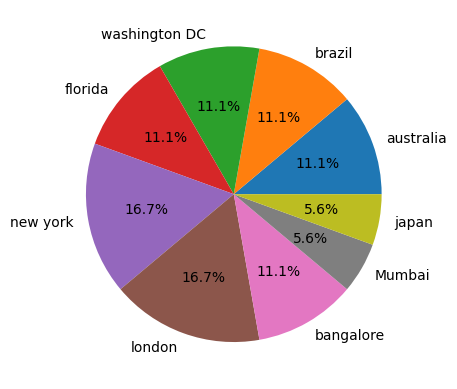

In [15]:
from matplotlib import pyplot

# In questo caso e' comodo avere una cypher projection per ogni nodo user che ha postato una foto con
# un certo tag (al cui interno si trova la proprieta' della location).
# Viene usata la cypher in quanto ci permette di modellare in modo piu' flessibile la relazione che
# che si vuole studiare
s.run('''match (source)-[r:POSTED]->()-->(target:Tag)
        with gds.graph.project('posted',source, target) as g
        return g.graphName as graph, g.nodeCount as nodes, g.relationshipCount as rels''')

res = s.run('''call gds.graph.relationships.stream('posted')
        yield sourceNodeId as u, targetNodeId as t
        with gds.util.asNode(u).name as user, collect(gds.util.asNode(t).location) as locs
        return distinct user, apoc.coll.frequencies(locs) as locations''').data()

df = pd.DataFrame(res)

print(df.shape) # Come si può notare non tutti gli user hanno postato qualcosa

# Prendiamo ora in esempio i primi 5 utenti
print(str(df.head(5)) + '\n')

# Scegliamo ad esempio il secondo per capire cosa stiamo cercando e cosa calcolare per capire
# se è in vacanza o meno.
# Prendiamo quindi dal dataframe (creato dalla query cypher) le locations taggate dall'utente Kenton_Kirlin
l = df.mask(df['user'] != 'Kenton_Kirlin').dropna()['locations']

# Si plotta il grafico a torta per capire la percentuale di ogni location
print(pyplot.pie([float(v['count']) for v in l[0]], labels=[str(k['item']) for k in l[0]], autopct='%1.1f%%'))

In questo caso si noti come l'utente ha una maggioranza di tag a NYC e Londra, che secondo la logica formulata possiamo dire che potrebbe essere due vacanze.
Non si puo' essere certi al 100% in quanto per poter capire l'accuratezza della previsione fatta bisorrebbe avere il dato (che normalmente instagram ha) della nazionalita' dell'utente e bisorrebbe anche avere un dataset piu' reale (molte properties sono state scartate perche' fabbricate e il grafo non e' small-world).
In ogni caso, se l'utente e' abbastanza attivo possiamo pensare con quanto la percentuale e' maggiore con quanto potrebbero essere foto di una vacanza. Se avessimo avuto dei timestamp sulla foto sarebbe stato possibile prevedere anche se lo era tutt'ora o meno.
Possiamo dire pero' che il dato e' comunque utile dato che Instagram potrebbe comunque decidere di pubblicizzare i servizi per luoghi visitati spesso; C'e' una percentuale molto alta che l'utente possa scattare altre foto del posto e che quindi si trovi ancora li. Ovviamente la piattaforma, avendo molti piu' dati rispetto a quelli che si hanno, riesce ad implementare tecniche di questo tipo.

Per quanto riguarda la problematica di un utente maligno si puo' dire che non si riesce a ricavare un modo automatico per calcolare se l'utente non e' a casa. L'unica maniera per l'utente maligno sarebbe quella di controllare manualmente un utente target che abiti nella sua zona e vedere quando vengono creati dei post taggati in un luogo diverso.
Sicuramente un modo per potersi proteggere da questa possibilita' potrebbe essere il mantenere l'account privato cosi da evitare che persone estranee possano 'spiare' i nostri post.
Un altro modo potrebbe anche essere il non mettere la nostra nazionalita' o non taggare la localita'che si sta visitando.

In [21]:
# Si potrebbe ora rafforzare le ipotesi cercando quali tra i post dell'utente hanno come tag
# beach e landscape.
# La teoria si basa sul fatto che si pensa che fare foto o video di una spiaggia o di un paesaggio 
# siano piu' comuni quando si e' in un posto nuovo e non quando si e' in uno che gia' si conosce com
# un paese/citta' di abitazione.
res = s.run('''call gds.graph.relationships.stream('posted')
            yield sourceNodeId as u, targetNodeId as t
            where gds.util.asNode(u).name = 'Kenton_Kirlin'
            return distinct gds.util.asNode(t).location as loc, 
            collect(distinct gds.util.asNode(t).text) as tags''').data()

# Per poter gia' filtrare per tipo di tag si puo' aggiungere in and nella clausola where
# (t.text = 'beach' or t.text = 'landscape')

print(pd.DataFrame(res))

# Il risultato e' quindi cio' che ci si aspettava (Londra contiene le parole chiave che si stava cercando)
# Come si e' pero' detto se avessimo la provenienza degli user si potrebbe provare al 100% la teoria.
# In questo caso si e' seguita un'ipotesi che potrebbe non essere veritiera e che quindi potrebbe
# risultare biased.

             loc                       tags
0      australia                    [smile]
1         brazil                      [fun]
2  washington DC     [concert, photography]
3        florida                    [party]
4       new york      [drunk, sunrise, lol]
5         london  [landscape, beach, happy]
6      bangalore          [beauty, fashion]
7         Mumbai                     [hair]
8          japan                    [style]


#### IL GIUSTO TAG

Scegliere il giusto tag per un post e' importante per attirare like e commenti? 
La domanda e' sicuramente interessante anche per capire come un'azienda che vuole farsi pubblicita' possa sfruttare certe parole chiave per darsi maggiore visibilita'.
Si puo' quindi ipotizzare che parole chiave come 'fun' o 'food' possano avere un peso maggiore contro parole come 'drunk' e 'stunning'.

Questo studio potrebbe anche servire per capire quali persone possono essere chiave sempre in ambito pubblicitario. La ricerca della persona piu' influente tramite lo studio delle relazioni di following abbiamo visto essere non praticabile (grafo quasi completo), possiamo quindi pensare che utenti con molti commenti e molti post creati possano essere anche le piu' influenti.

([<matplotlib.patches.Wedge object at 0x771701a30080>, <matplotlib.patches.Wedge object at 0x771701a30440>, <matplotlib.patches.Wedge object at 0x771701a8f0e0>, <matplotlib.patches.Wedge object at 0x771701807bf0>, <matplotlib.patches.Wedge object at 0x77170191d1c0>, <matplotlib.patches.Wedge object at 0x7717018562d0>, <matplotlib.patches.Wedge object at 0x771701856000>, <matplotlib.patches.Wedge object at 0x771701855970>, <matplotlib.patches.Wedge object at 0x771701857da0>, <matplotlib.patches.Wedge object at 0x7717018548f0>, <matplotlib.patches.Wedge object at 0x771701854ce0>, <matplotlib.patches.Wedge object at 0x771701855640>, <matplotlib.patches.Wedge object at 0x771701857b00>, <matplotlib.patches.Wedge object at 0x77170180c3b0>, <matplotlib.patches.Wedge object at 0x77170180cda0>, <matplotlib.patches.Wedge object at 0x77170180f6e0>, <matplotlib.patches.Wedge object at 0x77170180f440>, <matplotlib.patches.Wedge object at 0x77170180e360>, <matplotlib.patches.Wedge object at 0x771701

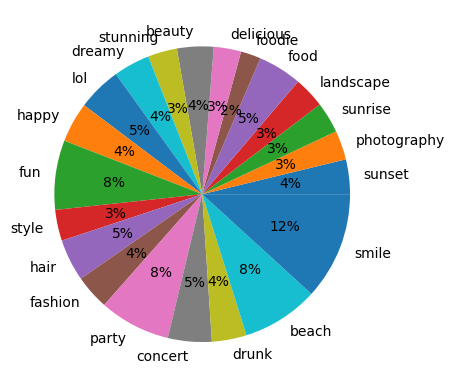

In [18]:
# Vediamo quanti post ci sono per ogni tipo di tag trovato.
# Come solito creaiamo una proiezione per evitare di sovraccaricare il grafo di partenza 
s.run('''call gds.graph.project('tagged', ['Post', 'Tag'], 'HAS_TAG')''')

res = s.run('''call gds.graph.relationships.stream('tagged')
            yield sourceNodeId as p, targetNodeId as t
            return distinct gds.util.asNode(t).text as text, count(gds.util.asNode(p)) as posts''').data()

df  = pd.DataFrame(res)


print(pyplot.pie([float(v) for v in df['posts']], labels=[str(k) for k in df['text']], autopct='%1.0f%%'))

In [ ]:
# Si nota dal grafico che smile, beach, party e fun sono i tag piu' gettonati.
# Guardiamo ora quali sono i tag piu' commentati.
s.run('''match (source:Comment)-[]->(:Post)-[]->(target:Tag)
      with gds.graph.project('commented',source, target) as g
      return g.graphName as graph, g.nodeCount as nodes, g.relationshipCount as rels''')

res = s.run('''call gds.graph.relationships.stream('commented')
            yield sourceNodeId as c, targetNodeId as t
            with gds.util.asNode(t).text as tag, gds.util.asNode(c) as comment
            return tag, count(comment) as comments order by comments desc limit 5''').data()

print(pd.DataFrame(res))
# Si nota che i tag piu' gettonati sono anche quelli piu' usati dagli utenti.
# Si pone quindi un problema che potra' pero' risolvere solo l'azienda che vuole farsi pubblicita':
# usare tag molto gettonati da' davvero visibilita'? In teoria cercando 'smile' non e' detto che 
# il proprio ad esca subito fuori e rischia di non essere visto.
# Inoltre non sempre un'azienda puo' fare una pubblicita' che riporta uno di questi contesti, ad esempio
# 'beach' non ha molto senso usarlo per un' azienda che vuole sponsorizzare medicinali.


In [28]:
# Continuiamo pero' con la ricerca e controlliamo quali sono i post con piu' like con un certo tag.
res = s.run('''match ()-[r:LIKE]->(p:Post)-->(t:Tag) return p.id as id, 
      collect(distinct t.text) as tags, count(r) as likes 
      order by likes desc limit 10''').data()

print(pd.DataFrame(res))
# Come previsto i tag piu' gettonati sono anche quelli nel post con piu' like.
# A esempio 'smile', che aveva la % maggiore di utilizzo , e' anche quello usato
# nei primi 10 post con piu' like.

# Si noti come dalle parole chiavi si possa anche ricostruire che tipo di post
# potesse essere! Cio' prova quanto sia importante saper riassumere il proprio post
# in una pubblicita' per richiamare chi potrebbe essere interessato a quegli argomenti.

    id                                              tags  likes
0  145               [fun, party, concert, drunk, smile]    240
1  227  [sunset, photography, sunrise, landscape, beach]    195
2  201  [sunset, photography, sunrise, landscape, beach]    195
3  155          [beauty, stunning, dreamy, beach, smile]    190
4   57               [fun, party, concert, drunk, smile]    185
5  230          [beauty, stunning, dreamy, beach, smile]    185
6  171          [beauty, stunning, dreamy, beach, smile]    180
7  136          [beauty, stunning, dreamy, beach, smile]    175
8  232          [beauty, stunning, dreamy, beach, smile]    175
9  182                    [beauty, dreamy, beach, smile]    172


## CONCLUSIONI

#### CHIUSURA SESSIONE

In [ ]:
s.close()
d.close()